**MACHINE LEARNING**

In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from matplotlib.figure import Figure
import pandas as pd

**Generating Data Sets**

Here two types of Dataset is generated 

**c**, **C** = Concentric Circles Dataset 

**g**, **G** = Gaussian Dataset 

In [0]:
def generateData( numExamples, distributionShape, numClasses = 2, numOutputs = 1):
    if((distributionShape == "c")or (distributionShape == "C")):
      j=0
      for i in range(numClasses):
          X,Y = [],[]
          for k in range(int(numExamples/numClasses)):
              r = (np.random.uniform(0+j,j+30) **0.5) * 1.5
              t = np.random.uniform(1,360)
              X.append((r*np.cos(t)))
              Y.append((r*np.sin(t)))
          j=j+70 
          X = np.array(X)
          Y = np.array(Y)
          X = X.reshape((len(X),1))
          Y = Y.reshape((len(Y),1))
          xy = np.append(X,Y,1)
          globals()['Class%d' % i] = np.append(xy,np.full((len(X),1),i),1)
   
    elif((distributionShape == "g")or (distributionShape == "G")):
      # plt.figure(figsize=(5,5))
      for i in range(0,numClasses):
        globals()['x%d' % i] = np.random.normal(i*10,2,int(numExamples/numClasses))
        globals()['x%d' % i] = globals()['x%d' % i].reshape((len(globals()['x%d' % i]),1)).       #globals() allows to assign variable name 
        globals()['y%d' % i] = np.random.normal(i*10,2,int(numExamples/numClasses))
        globals()['y%d' % i] = globals()['y%d' % i].reshape((len(globals()['y%d' % i]),1))
        # plt.scatter(globals()['x%d' % i],globals()['y%d' % i])
        globals()['Class%d' % i] = np.append(globals()['x%d' % i],globals()['y%d' % i],1)
        globals()['Class%d' % i] = np.append(globals()['Class%d' % i],np.full((len(globals()['x%d' % i]),1),i),1) 
    else: 
      print("\nEnter g or G for Guassian data, or c, C for circle")
    
    finalData = Class0
    for i in range(1,numClasses):
      finalData = np.append(finalData,globals()['Class%d' % i],0)
    # print("shape" , final.shape)
    return finalData

def addNoise(finalData,numClasses, noisePercentage):
  noise = int(len(finalData)* noisePercentage)
  classList = np.arange(numClasses)
  np.random.shuffle(finalData)
  for i in range(noise):
    c = np.random.choice(classList)
    while(finalData[i][2] == c):
      c = np.random.choice(classList)
    finalData[i][2] = c
  return finalData

def plotGraph(finalData,numClasses):
  # plt.figure(figsize=(6,6))
  classList = np.arange(numClasses)
  for i in range(numClasses-1,-1,-1):
    X,Y = [],[]
    for j in range(len(finalData)):
      if(finalData[j][2]==i):
        X.append(finalData[j][0])
        Y.append(finalData[j][1])
    plt.scatter(X,Y,edgecolors="w",s=30)

def splitData(x,percentage = 0.9):   
    split_from = int(len(x)*percentage)
    np.random.shuffle(x)
    training_data = x[0:split_from,:]
    test_data = x[split_from:,:]
    return training_data,test_data

**NEURAL NETWORK : TRAINING AND PREDICTING**

In [0]:
class Model:
  def __init__(self, numInputs=2, numOutputs=1, layerSize=2, numHiddenLayers=2, activationType ="R"):
    self.numInputs = numInputs
    self.numOutputs = numOutputs
    self.layerSize = layerSize
    self.numHiddenLayers = numHiddenLayers
    self.activationType = activationType
  
  def setInput(self,X_train):
    self.X_train = X_train
  
  def setTest(self,X_test):
    self.X_test = X_test
  
  def initWeights(self,mean = 0.0, std = 0.01):
    if(self.numHiddenLayers == 2):
      self.W1 = np.random.random((self.numInputs+1,self.layerSize)) 
      self.W2 = np.random.random((self.layerSize,self.layerSize)) 
      self.W3 = np.random.random((self.layerSize,self.numOutputs))
    elif(self.numHiddenLayers == 1):
      self.W1 = np.random.random((self.numInputs+1,self.layerSize)) 
      self.W2 = np.random.random((self.layerSize,self.numOutputs)) 
    

  def cross_entropy(self,predictions, targets, epsilon=1e-12):
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    loss = - np.mean(np.log(predictions) * targets) 
    return loss

  def getActivation(self,value):
    if(self.activationType == "S"):
      acti = 1/(1+np.exp(-value))
    elif(self.activationType == "R"):
      acti = np.maximum(0,value)
    elif(self.activationType == "L"):
      acti = value
    return acti

  def getDerivative(self,val):
    if(self.activationType == "S"):
      deriv = val*(1-val)
    elif(self.activationType == "R"):
      deriv = ((val>0)+0)
    elif(self.activationType == "L"):
      deriv = 1
    return deriv
 
  def test(self):
    predic = self.predict(self.X_test[:,:-1])
    if(self.numOutputs > 1):
      testTarget = np.array(pd.get_dummies(self.X_test[:,-1],dtype="int"))
      ttloss = self.cross_entropy(predic,testTarget)
    elif(self.numOutputs == 1):
      ttloss = (np.square(predic.ravel()-self.X_test[:,-1])).mean()
    return ttloss
 
  def train(self,numIter,learningRate):
    trainLoss = []
    testLoss = []
    X = self.X_train[:,:-1]
    X = np.append(np.ones((len(X),1)),X,1)
    targetValue = self.X_train[:,-1]
    targetValue = targetValue.reshape((len(targetValue),1))
    if(self.numOutputs > 1):
        targetValue = np.array(pd.get_dummies(targetValue.ravel(),dtype="int"))
    
    if(self.numHiddenLayers == 2):     
      for i in range(numIter):   
        H2 = np.dot(X,self.W1)
        A2 = self.getActivation(H2)
        H3 = np.dot(A2,self.W2)
        A3 = self.getActivation(H3)
        H4 = np.dot(A3,self.W3)
       
        if(self.numOutputs > 1):
          exp_max = np.exp(H4 - np.max(H4,axis=-1,keepdims=True))
          Y = exp_max/np.sum(exp_max,axis=-1,keepdims=True)
          tnloss = self.cross_entropy(Y,targetValue)
          ttloss = self.test()
          trainLoss.append(tnloss)
          testLoss.append(ttloss)
       
        else:
          Y = (1/(1+np.exp(-H4)))
          tnloss = (np.square(Y-targetValue)).mean()
          ttloss = self.test()
          trainLoss.append(tnloss)
          testLoss.append(ttloss)
    
        if(self.numOutputs > 1):
          dh4 = Y-targetValue
        
        else:
          dy = Y-targetValue
          dh4 = dy*Y*(1-Y)
        
        dw3 = np.dot(A3.T,dh4)
        da3 = np.dot(dh4,self.W3.T)
        dh3 = da3* self.getDerivative(A3)
        dw2 = np.dot(A2.T,dh3)
        da2 = np.dot(dh3,self.W2.T)
        dh2 = da2* self.getDerivative(A2)
        dw1 = np.dot(X.T,dh2)
        self.W1 = self.W1 - (dw1*learningRate)   #0.001
        self.W2 = self.W2 - (dw2*learningRate)
        self.W3 = self.W3 - (dw3*learningRate)
     
      error = np.array([trainLoss,testLoss]).T
      return error
      
    elif(self.numHiddenLayers == 1):
      for i in range(numIter):
        H2 = np.dot(X,self.W1)
        A2 = self.getActivation(H2)
        H3 = np.dot(A2,self.W2)

        if(self.numOutputs > 1):
          exp_max = np.exp(H3 - np.max(H3,axis=-1,keepdims=True))
          Y = exp_max/np.sum(exp_max,axis=-1,keepdims=True)
          tnloss = self.cross_entropy(Y,targetValue)
          ttloss = self.test()
          trainLoss.append(tnloss)
          testLoss.append(ttloss)

        else:
          Y = (1/(1+np.exp(-H3)))
          tnloss = (np.square(Y-targetValue)).mean()
          ttloss = self.test()
          trainLoss.append(tnloss)
          testLoss.append(ttloss)

        if(self.numOutputs > 1):
          delta_h3 = Y - targetValue
        else:
          dy = Y - targetValue
          delta_h3 = dy*Y*(1 - Y)
          
        dw2 = np.dot(A2.T,delta_h3)
        da2 = np.dot(delta_h3,self.W2.T)
        delta_h2 =  da2 * self.getDerivative(A2)
        dw1 = np.dot(X.T,delta_h2)
        self.W1 = self.W1 - (learningRate*dw1)
        self.W2 = self.W2 - (learningRate*dw2)
      error = np.array([trainLoss,testLoss]).T
      return error
      
  def predict(self,X1):
    X = X1
    X = np.append(np.ones((len(X),1)),X,1)
    if(self.numHiddenLayers == 2):
      H2 = np.dot(X,self.W1)
      A2 = self.getActivation(H2)
      H3 = np.dot(A2,self.W2)
      A3 = self.getActivation(H3)
      H4 = np.dot(A3,self.W3)
      if(self.numOutputs == 1):
        Y = (1/(1+np.exp(-H4)))
      else:
        exp_max = np.exp(H4 - np.max(H4,axis=-1,keepdims=True))
        Y = exp_max/np.sum(exp_max,axis=-1,keepdims=True)
      return Y


    elif (self.numHiddenLayers == 1):
      H2 = np.dot(X,self.W1)
      A2 = self.getActivation(H2)
      H3 = np.dot(A2,self.W2)
      if(self.numOutputs > 1):
        exp_max = np.exp(H3 - np.max(H3,axis=-1,keepdims=True))
        Y = exp_max/np.sum(exp_max,axis=-1,keepdims=True)
      else:
        Y = (1/(1+np.exp(-H3)))
      return Y

  
  def accuracy(self,predictions,target):
    if(self.numOutputs==1):
      l = list(np.around(predictions.ravel())==target)
      acc = (l.count(True)*100)/len(predictions)
    else:
      pre = []
      for i in predictions:
        pre.append(np.argmax(i))
      l = list(pre == target)
      acc = (l.count(True)*100)/len(predictions)
    return acc

  def decisionBoundry(self,X):
    par1 = np.arange(min(self.X_train[:,0])-1,max(self.X_train[:,0])+1,0.01)
    par2 = np.arange(min(self.X_train[:,1])-1,max(self.X_train[:,1])+1,0.01)
    a1,a2 = np.meshgrid(par1,par2)
    z = np.array([a1.ravel(),a2.ravel()]).T
    pre = self.predict(z)
    if(self.numOutputs == 1):
      pre = np.around(pre)
    else:
      pre_new = []
      for i in pre:
        pre_new.append(np.argmax(i))
      pre = np.array(pre_new)
    plt.contourf(a1,a2,pre.reshape(a1.shape))
    plt.scatter(X[:,0],X[:,1],c=X[:,-1],edgecolors="w")

**Part A : Generating Guassians and concentric circles with different number of classes**

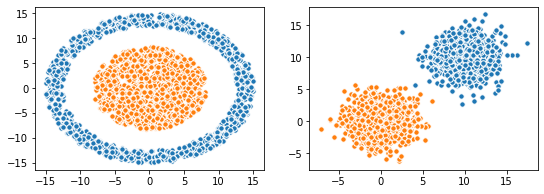

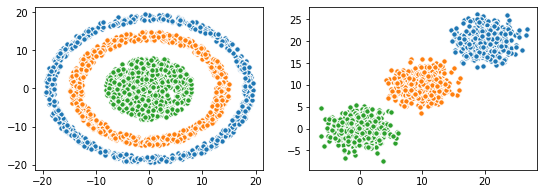

In [64]:
distributionShape = "c"
plt.figure(figsize=(9,3))
numClasses = 2
plt.subplot(121)
x = generateData(numExamples,distributionShape,numClasses,numOutputs=1)
plotGraph(x,numClasses)
distributionShape = "g"
plt.subplot(122)
x = generateData(numExamples,distributionShape,numClasses,numOutputs=1)
plotGraph(x,numClasses)
plt.figure(figsize=(9,3))
numClasses = 3
distributionShape = "c"
plt.subplot(121)
x = generateData(numExamples,distributionShape,numClasses,numOutputs=1)
plotGraph(x,numClasses)
distributionShape = "g"
plt.subplot(122)
x = generateData(numExamples,distributionShape,numClasses,numOutputs=1)
plotGraph(x,numClasses)





**Part B : Adding 0.1 noise probability for Concentric Circles dataset**

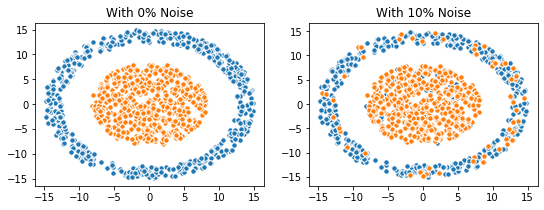

In [170]:
#noise
distributionShape = "c"
numClasses = 2
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
x = generateData(numExamples,distributionShape,numClasses,numOutputs=1)
plt.title("With 0% Noise")
plotGraph(x,numClasses)
x = addNoise(x,numClasses,0.1)
plt.subplot(1,2,2)
plt.title("With 10% Noise")
plotGraph(x,numClasses)

**Part C : Neural Net with 1 Hidden Layer**

Accuracy is  100.0 



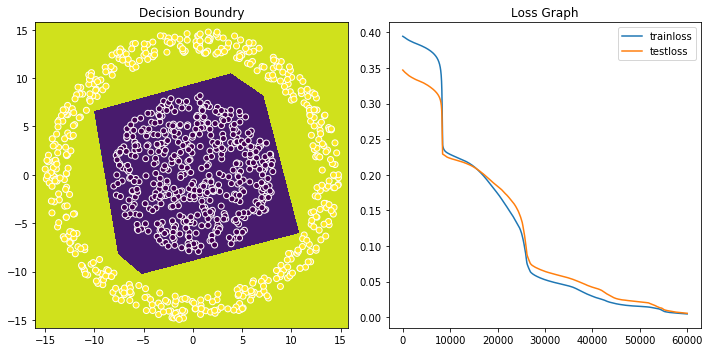

In [142]:
#for concentric circles using Relu Activation Function 
x = generateData(numExamples = 1000, distributionShape = "c",numClasses = 2, numOutputs=1)
X_train,X_test = splitData(x,0.9)
m = Model(numInputs=2,numOutputs = 1,layerSize=5,numHiddenLayers=1,activationType="R")
m.setInput(X_train)
m.setTest(X_test)
m.initWeights()
trainloss = m.train(60000,0.00001)
testLoss = m.test()
y = m.predict(X_test[:,:-1])
print("Accuracy is " ,m.accuracy(y,X_test[:,-1]),"\n")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
m.decisionBoundry(x)
plt.title("Decision Boundry")
plt.subplot(1,2,2)
plt.plot(np.arange(0,60000,1),trainloss[:,0])
plt.plot(np.arange(0,60000,1),trainloss[:,-1])
plt.legend(["trainloss","testloss"])
plt.title("Loss Graph")
plt.tight_layout()

Accuracy is  100.0 



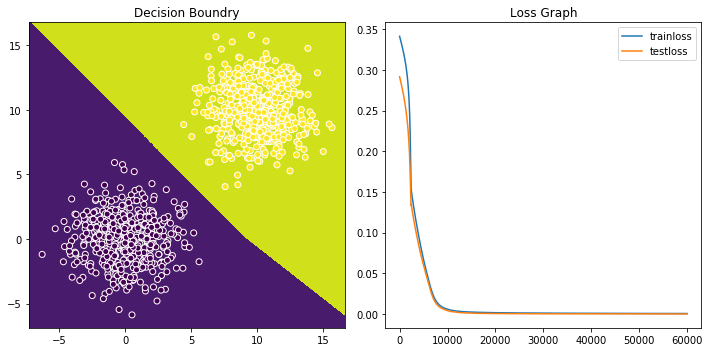

In [143]:
#for Cluster dataset
x = generateData(numExamples = 1000,distributionShape = "g",numClasses = 2, numOutputs=1)
X_train,X_test = splitData(x,0.9)
m = Model(numInputs=2,numOutputs = 1,layerSize=5,numHiddenLayers=1,activationType="R")
m.setInput(X_train)
m.setTest(X_test)
m.initWeights()
trainloss = m.train(60000,0.00001)
testLoss = m.test()
y = m.predict(X_test[:,:-1])
print("Accuracy is " ,m.accuracy(y,X_test[:,-1]),"\n")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
m.decisionBoundry(x)
plt.title("Decision Boundry")
plt.subplot(1,2,2)
plt.plot(np.arange(0,60000,1),trainloss[:,0])
plt.plot(np.arange(0,60000,1),trainloss[:,-1])
plt.legend(["trainloss","testloss"])
plt.title("Loss Graph")
plt.tight_layout()

**Part D : Refactor Code for two Hidden layers**

Circles dataset, Neural Network having **two** hidden layer

Accuracy is  100.0 



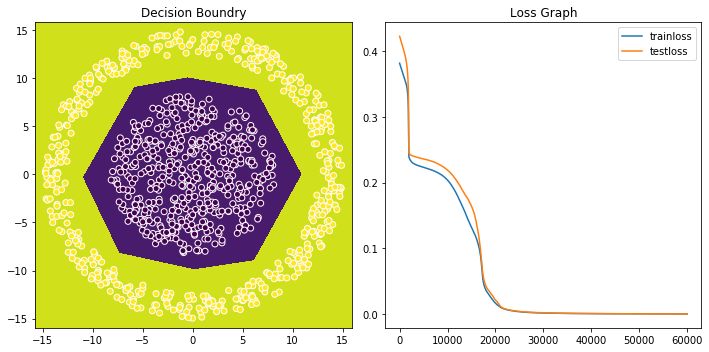

In [148]:
#concentric circles with two hidden layers 
x = generateData(numExamples = 1000,distributionShape = "c",numClasses = 2,numOutputs=1)
X_train,X_test = splitData(x,0.9)
m = Model(numInputs=2,numOutputs = 1,layerSize=5,numHiddenLayers=2,activationType="R")
m.setInput(X_train)
m.setTest(X_test)
m.initWeights()
trainloss = m.train(60000,0.00001)
testLoss = m.test()
y = m.predict(X_test[:,:-1])
print("Accuracy is " ,m.accuracy(y,X_test[:,-1]),"\n")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
m.decisionBoundry(x)
plt.title("Decision Boundry")
plt.subplot(1,2,2)
plt.plot(np.arange(0,60000,1),trainloss[:,0])
plt.plot(np.arange(0,60000,1),trainloss[:,-1])
plt.legend(["trainloss","testloss"])
plt.title("Loss Graph")
plt.tight_layout()

Gaussian dataset, Neural Network having **two** hidden layers

Accuracy is  100.0 



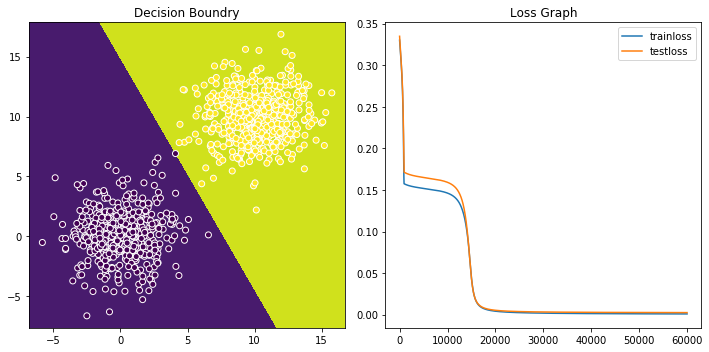

In [147]:
x = generateData(numExamples = 1000,distributionShape="g",numClasses=2,numOutputs=1)
X_train,X_test = splitData(x,0.9)
m = Model(numInputs=2,numOutputs = 1,layerSize=3,numHiddenLayers=2,activationType="R")
m.setInput(X_train)
m.setTest(X_test)
m.initWeights()
trainloss = m.train(60000,0.00001)
testLoss = m.test()
y = m.predict(X_test[:,:-1])
print("Accuracy is " ,m.accuracy(y,X_test[:,-1]),"\n")
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
m.decisionBoundry(x)
plt.title("Decision Boundry")
plt.subplot(1,2,2)
plt.plot(np.arange(0,60000,1),trainloss[:,0])
plt.plot(np.arange(0,60000,1),trainloss[:,-1])
plt.legend(["trainloss","testloss"])
plt.title("Loss Graph")
plt.tight_layout()

**Part E : Variable number of hidden units**

Here, 1-5 numbers of hidden units are passed, with two hidden layer


Accuracy with 1 neurons is  43.0 



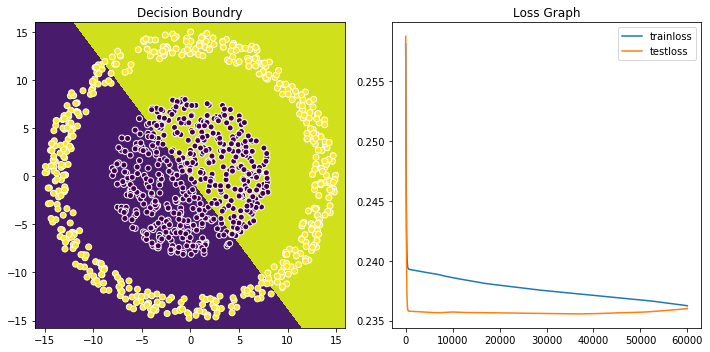


Accuracy with 2 neurons is  65.0 



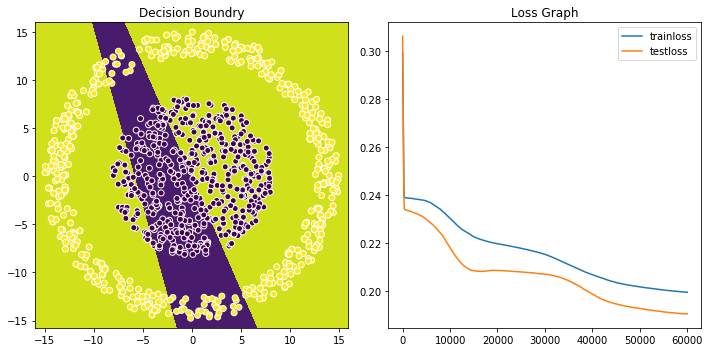


Accuracy with 3 neurons is  94.0 



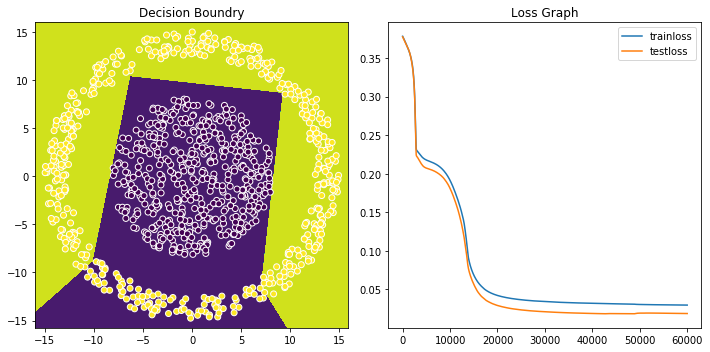


Accuracy with 4 neurons is  96.0 



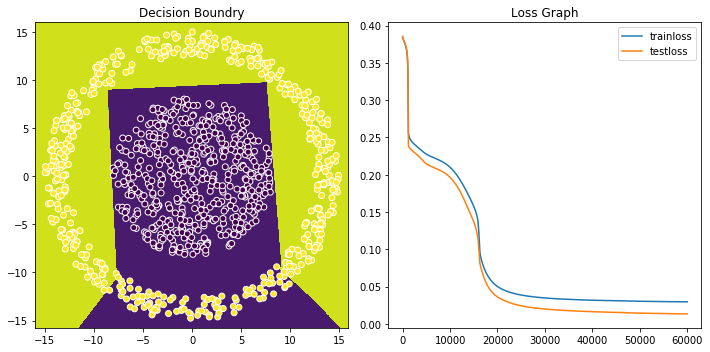


Accuracy with 5 neurons is  100.0 



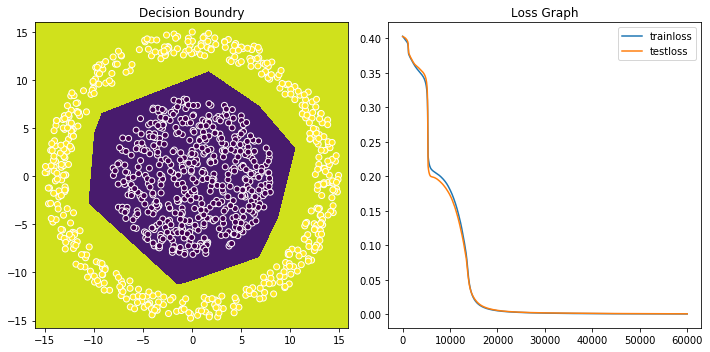

In [154]:
#variable hidden Unit
x = generateData(numExamples = 1000,distributionShape = "c",numClasses = 2,numOutputs=1)
X_train,X_test = splitData(x,0.9)
for i in range(1,6):
  m = Model(numInputs=2,numOutputs = 1,layerSize=i,numHiddenLayers=2,activationType="R")
  m.setInput(X_train)
  m.setTest(X_test)
  m.initWeights()
  trainloss = m.train(60000,0.00001)
  testLoss = m.test()
  y = m.predict(X_test[:,:-1])
  print("\nAccuracy with %d neurons is "%i ,m.accuracy(y,X_test[:,-1]),"\n")
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  m.decisionBoundry(x)
  plt.title("Decision Boundry")
  plt.subplot(1,2,2)
  plt.plot(np.arange(0,60000,1),trainloss[:,0])
  plt.plot(np.arange(0,60000,1),trainloss[:,-1])
  plt.legend(["trainloss","testloss"])
  plt.title("Loss Graph")
  plt.tight_layout()
  plt.show()

Above, neural network with ReLu Activation Function and 2 Hidden Layers,using  different Range (1,6) of Neurons is presented.

**Part F : Possible Activation Function (S, R, L)**


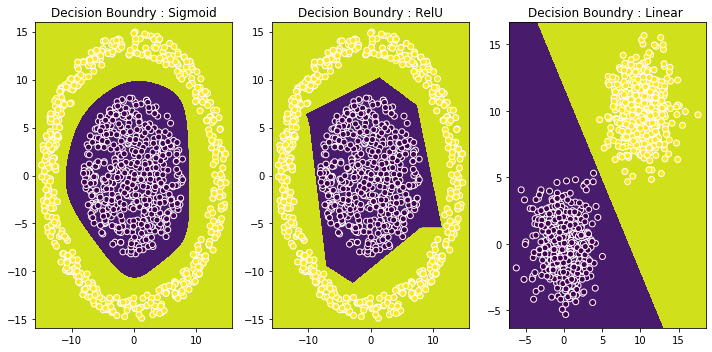

In [169]:
plt.figure(figsize=(10,5))
#for Sigmoid Activation Function
x = generateData(numExamples = 1000,distributionShape="c",numClasses=2,numOutputs=1)
X_train,X_test = splitData(x,0.9)
m = Model(numInputs=2,numOutputs = 1,layerSize=5,numHiddenLayers=2,activationType="S")
m.setInput(X_train)
m.setTest(X_test)
m.initWeights()
trainloss = m.train(60000,0.001)
testLoss = m.test()
y = m.predict(X_test[:,:-1])
plt.subplot(1,3,1)
m.decisionBoundry(x)
plt.title("Decision Boundry : Sigmoid")

#For ReLu Activation Function
m = Model(numInputs=2,numOutputs = 1,layerSize=6,numHiddenLayers=2,activationType="R")
m.setInput(X_train)
m.setTest(X_test)
m.initWeights()
trainloss = m.train(60000,0.00001)
testLoss = m.test()
y = m.predict(X_test[:,:-1])
plt.subplot(1,3,2)
m.decisionBoundry(x)
plt.title("Decision Boundry : RelU")

#For Linear Activation Function
x = generateData(numExamples = 1000,distributionShape="g",numClasses=2,numOutputs=1)
X_train,X_test = splitData(x,0.9)
m = Model(numInputs=2,numOutputs = 1,layerSize=5,numHiddenLayers=2,activationType="L")
m.setInput(X_train)
m.setTest(X_test)
m.initWeights()
trainloss = m.train(60000,0.00001)
testLoss = m.test()
y = m.predict(X_test[:,:-1])
plt.subplot(1,3,3)
m.decisionBoundry(x)
plt.title("Decision Boundry : Linear ")
plt.tight_layout()
plt.show()

For above, Cluster Dataset was used to illustrate Linear Function, as Linear Function is not suitable for concentric circles dataset. 

**Part G : Multiple output units, using softmax and a cross-entropy error.**


Accuracy for ReLU using Softmax for output 2  100.0 



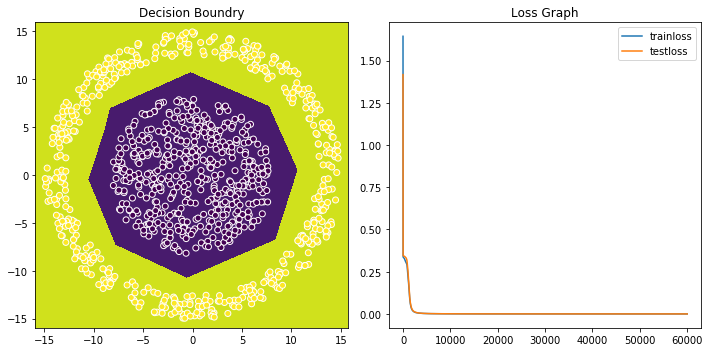

Accuracy for ReLU using Softmax for output 3  100.0 



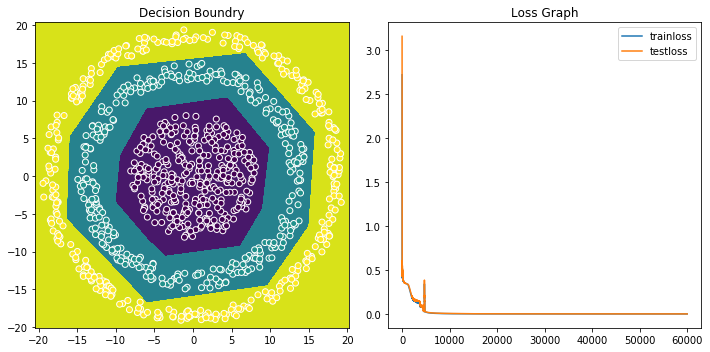

Accuracy for ReLU using Softmax for output 4  100.0 



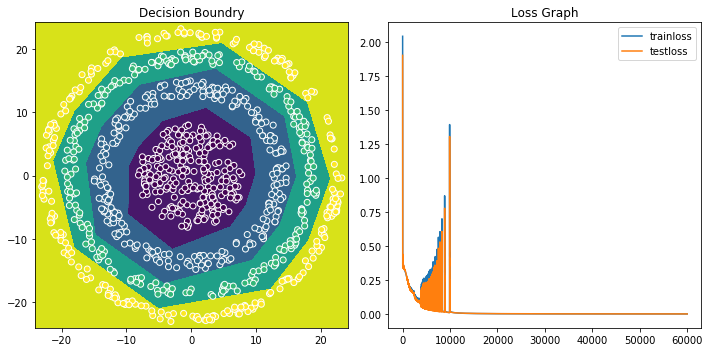

In [163]:
for i in range(2,5):
  x = generateData(numExamples = 1000,distributionShape="c",numClasses=i,numOutputs=1)
  X_train,X_test = splitData(x,0.9)
  m = Model(numInputs=2,numOutputs = i ,layerSize=6,numHiddenLayers=2,activationType="R")
  m.setInput(X_train)
  m.setTest(X_test)
  m.initWeights()
  trainloss = m.train(60000,0.00001)
  testLoss = m.test()
  y = m.predict(X_test[:,:-1])
  print("Accuracy for ReLU using Softmax for output %d "%i ,m.accuracy(y,X_test[:,-1]),"\n")
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  m.decisionBoundry(x)
  plt.title("Decision Boundry")
  plt.subplot(1,2,2)
  plt.plot(np.arange(0,60000,1),trainloss[:,0])
  plt.plot(np.arange(0,60000,1),trainloss[:,-1])
  plt.legend(["trainloss","testloss"])
  plt.title("Loss Graph")
  plt.tight_layout()
  plt.show()

Above, Multiple dataclass with multiple output was computed using **Softmax** and loss is calculated using **cross-entropy** error. 

**The code is cabable of clasifying both types of dataset and with any number of neurons and outputs.**

It performs sigmoid if output == 1, else it will perform softmax. For hidden units, it can perform Sigmoid, ReLU or Linear

**REFERENCES**

 [Globals()](https://stackoverflow.com/questions/46617233/how-to-create-a-varying-variable-name-in-python)

[Cross-Entropy](https://stackoverflow.com/questions/47377222/what-is-the-problem-with-my-implementation-of-the-cross-entropy-function)  
 
[Sub-plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot.html) 